# ENCH 670 - Machine Learning for Optical Properties of Chlorins
### FACS: Fluorescence and Absorbance Computational Science – Group 4

#### Citation for using scikit-learn
Scikit-learn: Machine Learning in Python, Pedregosa et al., JMLR 12, pp. 2825-2830, 2011

Using Random Forest from sklearn

## 1. Import Libraries

In [4]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

## 2. Data Preparation
add a few sentences about the dataset.
An important step for data preparation is dealing with missihng values. First we check if the dataset has any missing values and then we fill missing values with the value that gives the best results.

In [6]:
#Import CSV file
df = pd.read_csv('raw_dataset.csv')
#Check for missing values
print('Missing values:', df.isnull().sum())
#Check for SMILES with zero value in dataset
print('Zero SMILES:', (df['smiles'] == 0).sum())
#Check the mean, max, and min values of the dataset
mean_value = df['emission'].mean()
min_value = df['emission'].min()
max_value = df['emission'].max()
print(f"mean:{int(mean_value)}, max:{int(max_value)}, min:{int(min_value)}")

Missing values: smiles       0
emission    97
dtype: int64
Zero SMILES: 0
mean:545, max:1045, min:296


In [7]:
#Filling missing values
df = df.fillna(695)
#Print the first 10 rows of the dataset
df.head(10)

,smiles,emission
0,CC(C)(CC1C=C2C3)C(N=1[Zn](N2C(C=3)=C1)(N2C3C4)...,605.0
1,CC(C)(CC1C=C(C=C2)NC2=CC2C3)C(N=1)=CC(=CC1)NC=...,634.0
2,CC(C)(CC1/C=C(\N2C3=C4)C=C3)/C(N=1)=C/C(=CC1)N...,610.0
3,CC(C)(CC1C=C2C3)C(N=1[Zn](N1C45)(N2C2C=3)N(C(C...,607.0
4,CC(C)(CC1C=C(NC2=CC34)C=C2)C(N=1)=CC(NC1C(C(C=...,637.0
5,CC(=CC=C1/C(C(=CC2)N(C=2C=C2C3(C)C)[Zn](N2=C(C...,608.0
6,CC(=CC=C1C(C(NC2C=C(N=C3C4)C(C3)(C)C)=CC=2)=C(...,639.0
7,CC(C)(CC1C=C2C3)C(N=1[Zn](N1C45)(N2C2C=3)N(=C(...,608.0
8,CC(C)(CC1C=C(C=C2)NC2=C(C23)C(C=CC4)=CC=4)C(N=...,637.0
9,CC(C)(CC1/C=C(/C=C2)N3C2=C2C(=CC=C4)C=C4)/C(N=...,695.0


## 3. SMILES Cleaning Pipeline
The nex step is to remove unvalid and duplicated SMILES from the dataset. We have achieved this goal through 3 steps:

1. Canonicalize SMILES using RDKit.
2. Remove invalid SMILES entries.
3. Eliminate duplicate molecules based on canonical SMILES.

In [9]:
#Define canonicalization function
def canonicalize(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles) #Convert the SMILES string to an RDKit molecule object
        if mol is not None: #If the molecule object is valid, return its canonical SMILES
            return Chem.MolToSmiles(mol, canonical=True)
    #If an error occurs during conversion, return None
    except:
        return None  
    return None

#Apply canonicalization function to the dataset
df['canonical_smiles'] = df['smiles'].apply(canonicalize)

#Remove invalid SMILES from the dataset
df = df[df['canonical_smiles'].notna()]

#Drop duplicates from the dataset
df_unique = df.drop_duplicates(subset='canonical_smiles').reset_index(drop=True)

#Save cleaned dataset
#df_unique.to_csv("smiles_dataset_unique.csv", index=False)

#Print statistical data
print(f"Original count: {len(df)}")
print(f"Unique molecules: {len(df_unique)}")
print(f"Duplicates detected: {len(df) - len(df_unique)}")

Original count: 4766
Unique molecules: 3282
Duplicates detected: 1484


## 4. Emission Wavelength Distribution
In the next setp, we visualize the distribution of emission wavelengths in the cleaned dataset.

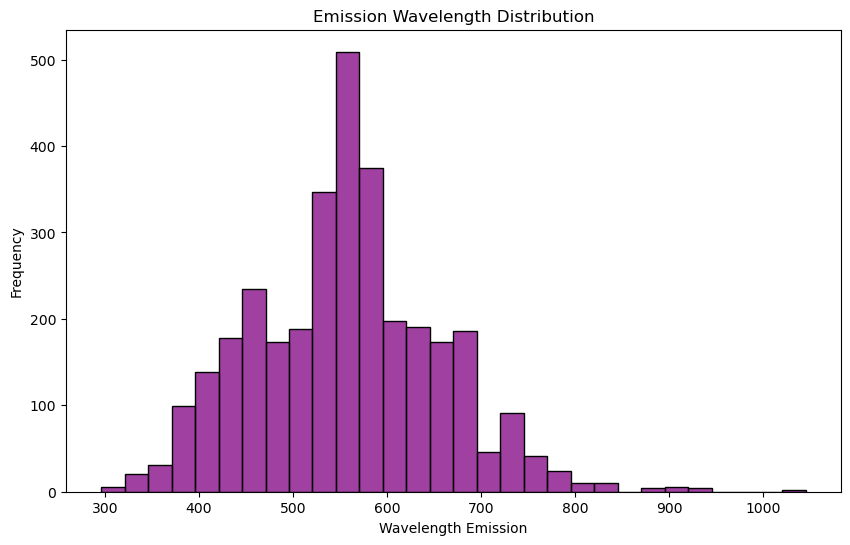

In [11]:
plt.figure(figsize=(10, 6))
#Plot histogram distribution
sns.histplot(df_unique['emission'], bins=30, color="purple")
#Define title and lables
plt.title('Emission Wavelength Distribution')
plt.xlabel('Wavelength Emission')
plt.ylabel('Frequency')

plt.show()

## 5. Feature Extraction
As the next step, we define the label and molecular features to be used in machine learning model.
Molecular fingerprints are generated using RDKit’s Morgan fingerprinting method. Radius=2 captures atom neighborhoods up to 2 bonds away and fpSize=4096 sets the fingerprint length (number of bits).

In [13]:
#Define target and feature
smiles_list = df_unique['smiles']
targets = df_unique['emission']
#Define a function for using Morgan generator
morgan_gen = GetMorganGenerator(radius=2, fpSize=4096)

def smiles_to_morgan_fp(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles) #Convert SMILES to RDKit molecule
        if mol:
            return list(morgan_gen.GetFingerprint(mol)) #Return fingerprint as list of bits
    except:
        pass
    return None
#Generate Morgan fingerprints for each SMILES in the dataset
fps = [smiles_to_morgan_fp(smiles) for smiles in df_unique['smiles']]
#Filter out entries with invalid or missing fingerprints
valid_idx = [i for i, fp in enumerate(fps) if fp is not None] 
#Prepare feature matrix X (Morgan) and target vector y (wavelength) for machine learning
X = np.array([list(fps[i]) for i in valid_idx])                  
y = df_unique.iloc[valid_idx]['emission'].values 

## 6. Machine Learning Model
In the next step, we develop Random Forest regression model. As stated previously, the label is emission wavelength 
and features are the fingerprints generated based on SMILES strings. First, we split the dataset into a train and test set.

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

Now, we train the model to learn to predict emission wavelengths based on molecular structure represented by Morgan 
fingerprints.

In [17]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

## 7. Model Performance on Training Set
After training the Random Forest Regressor, we evaluate its performance using Root Mean Squared Error (RMSE) and R² Score on the training data.

In [19]:
#Predict on the training set
y_train_pred = rf.predict(X_train) 
#Calculate evaluation metrics
RMSE = np.sqrt(mean_squared_error(y_train, y_train_pred))
R2 = r2_score(y_train, y_train_pred)
#Print results
print(f"RMSE: {RMSE:.2f}")
print(f"R² Score: {R2:.2f}")

RMSE: 14.78
R² Score: 0.98


## 8. Visualization: Measured vs. Predicted Emission (Training Set)
This plot provides a visual assessment of how well the Random Forest model's predictions match the actual emission values on the training set.

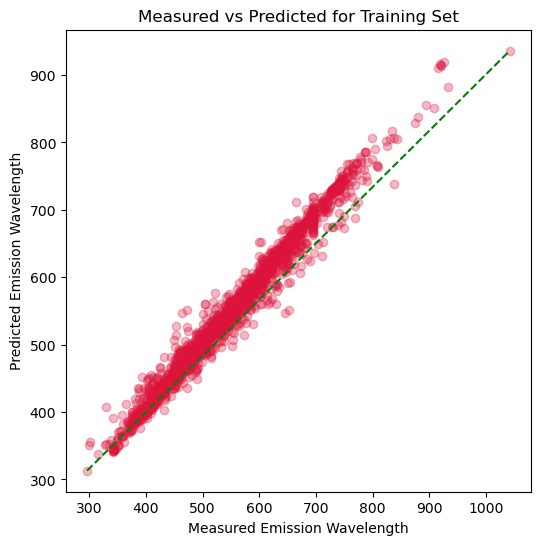

In [21]:
plt.figure(figsize=(6,6))
# Scatter plot of actual vs predicted values
plt.scatter(y_train, y_train_pred, alpha=0.3, color='crimson')
# Reference line (perfect prediction)
plt.plot([y_train.min(), y_train.max()], [y_train_pred.min(),y_train_pred.max()], '--g')
plt.xlabel("Measured Emission Wavelength")
plt.ylabel("Predicted Emission Wavelength")
plt.title("Measured vs Predicted for Training Set")
plt.savefig('Final_graph.pdf')

plt.show()

## 9. Model Performance on Test Set
To evaluate the generalization ability of the trained Random Forest model, we evaluate its performance on unseen data (test set) using RMSE and R² Score.

In [23]:
#Predict on the test set
y_test_pred = rf.predict(X_test)
#Calculate evaluation metrics
RMSE = np.sqrt(mean_squared_error(y_test, y_test_pred))
R2 = r2_score(y_test, y_test_pred)
#Print results
print(f"RMSE: {RMSE:.2f}")
print(f"R² Score: {R2:.2f}")

RMSE: 39.92
R² Score: 0.86


## 10. Visualization: Measured vs. Predicted Emission (Test Set)

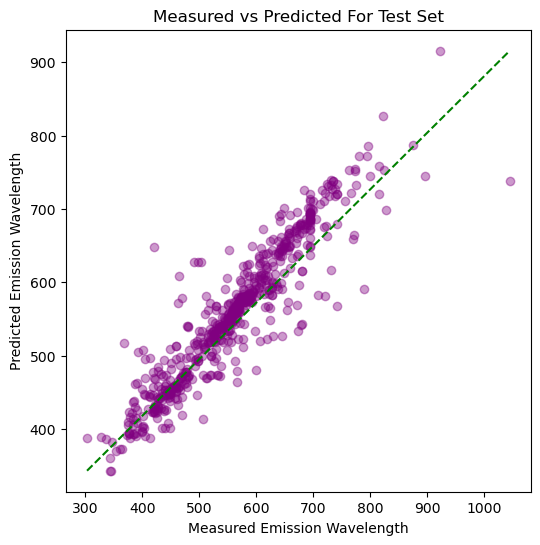

In [25]:
plt.figure(figsize=(6,6))
# Scatter plot of actual vs predicted values
plt.scatter(y_test, y_test_pred, alpha=0.4, color='purple')
# Reference line (perfect prediction)
plt.plot([y_test.min(), y_test.max()], [y_test_pred.min(),y_test_pred.max()], '--g')
plt.xlabel("Measured Emission Wavelength")
plt.ylabel("Predicted Emission Wavelength")
plt.title("Measured vs Predicted For Test Set")
#plt.savefig('Final_graph.pdf')

plt.show()

## 11. End-to-End ML Pipeline: SMILES to Emission Wavelength

This pipeline accepts a SMILES string from the user, converts it to a Morgan fingerprint, and predicts the 
corresponding emission wavelength using the trained Random Forest Regressor.

In [27]:
#Function to predict the emission wavelength from a given SMILES string
def predict_wavelength_from_smiles(smiles, model, morgan_gen):
    try:
         #Convert the input SMILES string to an RDKit molecule object
        mol = Chem.MolFromSmiles(smiles)
        #Handle invalid SMILES input
        if mol is None:
            return "Invalid SMILES string; please enter a valid SMILES string"
        
        #Convert to Morgan fingerprint
        fp = list(morgan_gen.GetFingerprint(mol))
        fp_array = np.array(fp).reshape(1, -1) #Reshape the fingerprint into the format expected by the model

        #Predict emission wavelength using the trained model
        prediction = model.predict(fp_array)[0]
        return f"Predicted emission wavelength: {prediction:.2f} nm" #Return the prediction with two decimals
    #Handle errors that might occur during prediction
    except Exception as e:
        return f"Error during prediction: {str(e)}"

#Run an interactive SMILES prediction loop
if __name__ == '__main__':
    while True:
        #Prompt the user to input a SMILES string or exit
        user_input = input("Enter a SMILES string or type exit to quit: ").strip()
        #Exit the loop if the user types 'exit'
        if user_input.lower() == 'exit':
            break
        #Make and print the prediction
        result = predict_wavelength_from_smiles(user_input, rf, morgan_gen)
        print(result)

Enter a SMILES string or type exit to quit:  exit
